## Решаем задачу регрессии для IC50

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.svm import SVR
from joblib import dump

from sklearn.tree import DecisionTreeRegressor, plot_tree

from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import GradientBoostingRegressor

In [18]:
df = pd.read_excel('../Data/Processed/processed_info.xlsx')

# Сразу удалим CC50 и SI, так как они рассчитываются друг через друга.
df.drop(['CC50, mM', 'SI'], axis=1, inplace=True)

## Линейная регрессия

In [3]:
X_top = df.drop(['IC50, mM'], axis=1)
y = df['IC50, mM']

# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X_top, y, test_size=0.2, random_state=42
)

# Обучение линейной регрессии
model = LinearRegression()
model.fit(X_train, y_train)

# Предсказание и оценка модели
y_pred = model.predict(X_test)

# Метрики качества
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Mean Squared Error (MSE): 255240.4480
R-squared (R²): 0.2348


## PCA

Исходное число признаков: 131
Выбранное число компонент: 34
Объясненная дисперсия: 0.8040


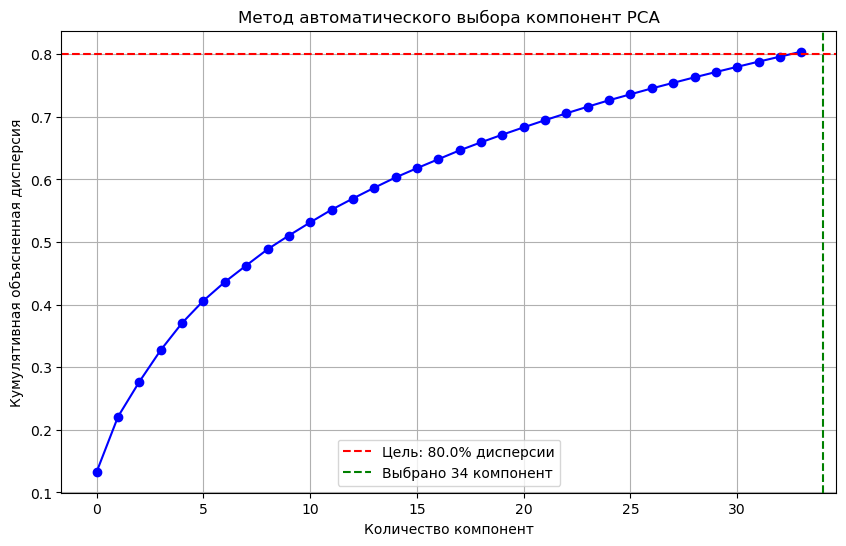


Вклад каждой компоненты:
Компонента 1: 0.1330
Компонента 2: 0.0881
Компонента 3: 0.0558
Компонента 4: 0.0505
Компонента 5: 0.0433
Компонента 6: 0.0356
Компонента 7: 0.0298
Компонента 8: 0.0264
Компонента 9: 0.0258
Компонента 10: 0.0220
Компонента 11: 0.0210
Компонента 12: 0.0203
Компонента 13: 0.0179
Компонента 14: 0.0172
Компонента 15: 0.0165
Компонента 16: 0.0148
Компонента 17: 0.0143
Компонента 18: 0.0142
Компонента 19: 0.0128
Компонента 20: 0.0122
Компонента 21: 0.0117
Компонента 22: 0.0114
Компонента 23: 0.0110
Компонента 24: 0.0106
Компонента 25: 0.0103
Компонента 26: 0.0095
Компонента 27: 0.0094
Компонента 28: 0.0089
Компонента 29: 0.0088
Компонента 30: 0.0085
Компонента 31: 0.0083
Компонента 32: 0.0083
Компонента 33: 0.0080
Компонента 34: 0.0079

Анализ вклада исходных признаков:

Топ-3 признака для PC1:
- SMR_VSA1 (вклад: 0.1823)
- TPSA (вклад: 0.1741)
- MolWt (вклад: 0.1705)

Топ-3 признака для PC2:
- BalabanJ (вклад: 0.2249)
- NumAliphaticRings (вклад: -0.2008)
- RingCount 

In [5]:
X = df.drop(['IC50, mM'], axis=1)
y = df['IC50, mM']

# Стандартизация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

target_variance = 0.8  # Уровень сохраняемой дисперсии
pca = PCA(n_components=target_variance)
X_pca = pca.fit_transform(X_scaled)

print(f"Исходное число признаков: {X.shape[1]}")
print(f"Выбранное число компонент: {pca.n_components_}")
print(f"Объясненная дисперсия: {np.sum(pca.explained_variance_ratio_):.4f}")

# Визуализация кумулятивной дисперсии
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'bo-')
plt.axhline(y=target_variance, color='r', linestyle='--', label=f'Цель: {target_variance*100}% дисперсии')
plt.axvline(x=pca.n_components_, color='g', linestyle='--', label=f'Выбрано {pca.n_components_} компонент')
plt.xlabel('Количество компонент')
plt.ylabel('Кумулятивная объясненная дисперсия')
plt.title('Метод автоматического выбора компонент PCA')
plt.legend()
plt.grid()
plt.show()

print("\nВклад каждой компоненты:")
for i, ratio in enumerate(pca.explained_variance_ratio_):
    print(f"Компонента {i+1}: {ratio:.4f}")

print("\nАнализ вклада исходных признаков:")
# Создаем DataFrame с весами компонент
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=X.columns
)

# Для каждой компоненты выводим топ-3 самых влиятельных признака
top_features_per_pc = {}
for pc in loadings.columns:
    # Берем признаки с наибольшим абсолютным вкладом
    top_features = loadings[pc].abs().sort_values(ascending=False).head(3).index.tolist()
    top_features_per_pc[pc] = top_features
    print(f"\nТоп-3 признака для {pc}:")
    for feature in top_features:
        print(f"- {feature} (вклад: {loadings.loc[feature, pc]:.4f})")

all_top_features = list(set([feature for features in top_features_per_pc.values() for feature in features]))
print("\nУникальные признаки, вносящие наибольший вклад в объясненную дисперсию:")
for i, feature in enumerate(all_top_features, 1):
    print(f"{i}. {feature}")

# Суммарный вклад каждого признака по всем компонентам
print("\nСуммарный вклад признаков по всем компонентам:")
total_contribution = loadings.abs().sum(axis=1).sort_values(ascending=False)
print(total_contribution.head(10))  # Топ-10 самых важных признаков

# Выбираем топ-40 признаков по суммарному вкладу
top_features = total_contribution.head(40).index.tolist()
X_filtered = X[top_features]
print("\nТоп-40 признаков:", top_features)

## Линейная регрессия + PCA

Mean Squared Error (MSE): 258632.9848
R-squared (R²): 0.2246


C:\Users\user\AppData\Local\Temp\ipykernel_17236\1630809473.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette='viridis')


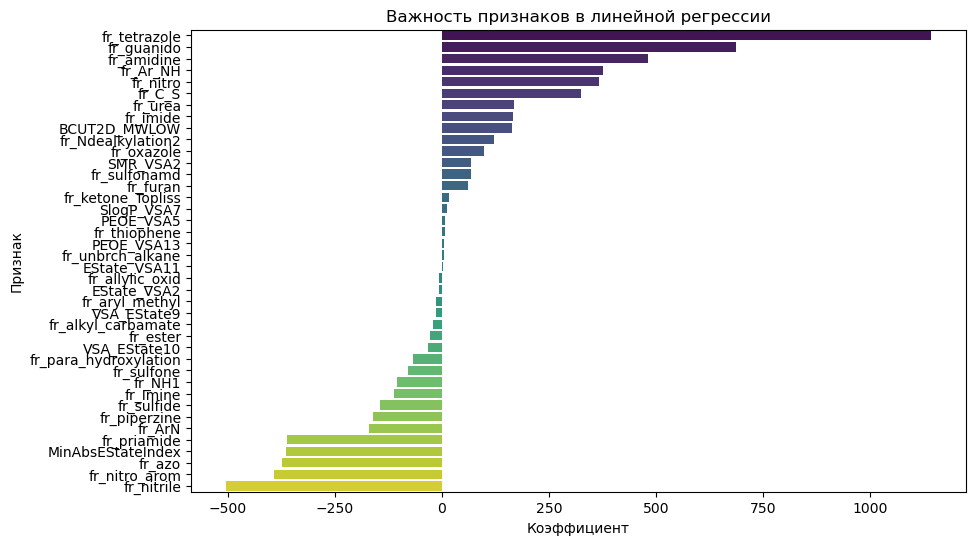

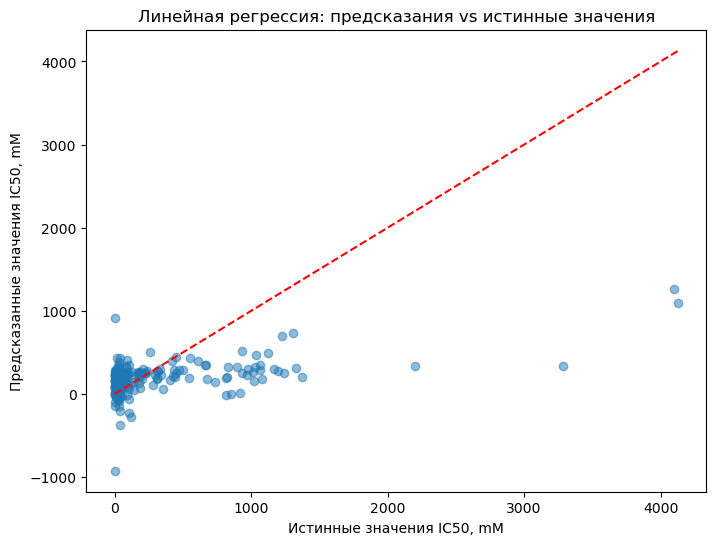


Уравнение регрессии:
 IC50 = -1198.800 + 13.282*SlogP_VSA7 + 324.846*fr_C_S + -502.958*fr_nitrile + 1.810*EState_VSA11 + 375.080*fr_Ar_NH + 482.077*fr_amidine + -143.358*fr_sulfide + 365.918*fr_nitro + -373.102*fr_azo + 686.608*fr_guanido + 7.237*fr_thiophene + 167.459*fr_urea + -169.524*fr_ArN + 68.147*SMR_VSA2 + -66.060*fr_para_hydroxylation + 1141.086*fr_tetrazole + 97.969*fr_oxazole + -391.591*fr_nitro_arom + 4.633*fr_unbrch_alkane + -20.780*fr_alkyl_carbamate + 164.803*BCUT2D_MWLOW + -364.153*MinAbsEStateIndex + 4.859*PEOE_VSA13 + -13.493*VSA_EState9 + -27.324*fr_ester + 67.477*fr_sulfonamd + -78.408*fr_sulfone + -360.900*fr_priamide + -32.094*VSA_EState10 + -12.605*fr_aryl_methyl + 122.568*fr_Ndealkylation2 + -103.415*fr_NH1 + 166.831*fr_imide + -161.072*fr_piperzine + -110.935*fr_Imine + 16.486*fr_ketone_Topliss + 60.856*fr_furan + 8.018*PEOE_VSA5 + -6.818*EState_VSA2 + -5.379*fr_allylic_oxid


In [6]:
X_top = df[top_features]
y = df['IC50, mM']

# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X_top, y, test_size=0.2, random_state=42
)

# Обучение линейной регрессии
model = LinearRegression()
model.fit(X_train, y_train)

# Предсказание и оценка модели
y_pred = model.predict(X_test)

# Метрики качества
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# Визуализация важности признаков
coef_df = pd.DataFrame({
    'Feature': top_features,
    'Coefficient': model.coef_
}).sort_values('Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette='viridis')
plt.title('Важность признаков в линейной регрессии')
plt.xlabel('Коэффициент')
plt.ylabel('Признак')
plt.show()

# График предсказаний vs истинных значений
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Истинные значения IC50, mM')
plt.ylabel('Предсказанные значения IC50, mM')
plt.title('Линейная регрессия: предсказания vs истинные значения')
plt.show()

# Вывод уравнения регрессии
equation = "IC50 = {:.3f}".format(model.intercept_)
for feature, coef in zip(top_features, model.coef_):
    equation += " + {:.3f}*{}".format(coef, feature)
print("\nУравнение регрессии:\n", equation)

## Elastic Net

E:\Programs\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.991e+07, tolerance: 7.582e+03
  model = cd_fast.enet_coordinate_descent(
E:\Programs\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.850e+07, tolerance: 7.033e+03
  model = cd_fast.enet_coordinate_descent(
E:\Programs\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.101e+07, tolerance: 7.638e

Лучшие параметры: {'alpha': 1, 'l1_ratio': 0.7}
MSE: 248407.7923
R²: 0.2553


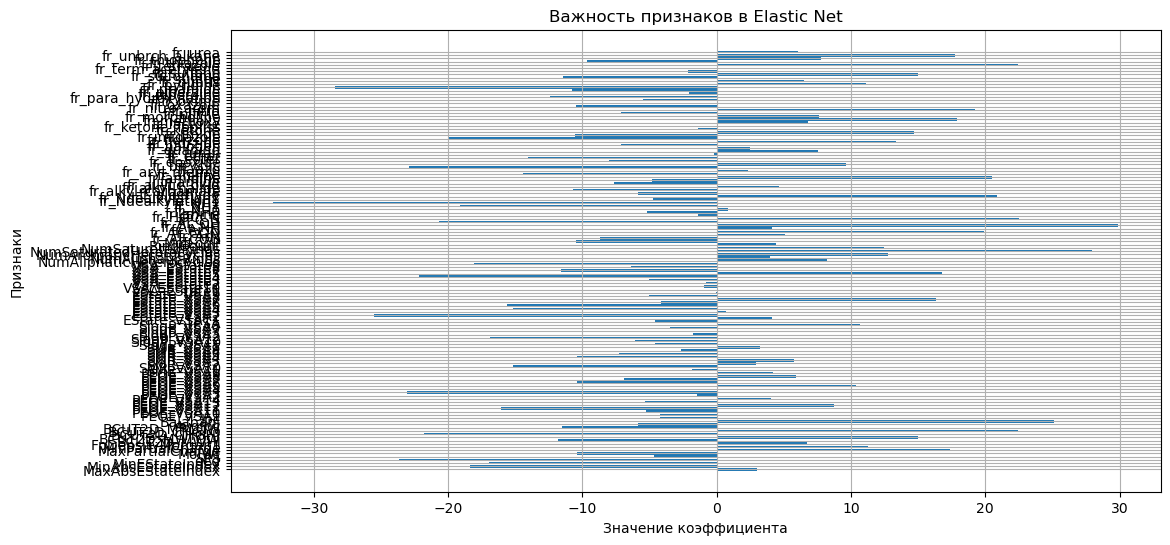

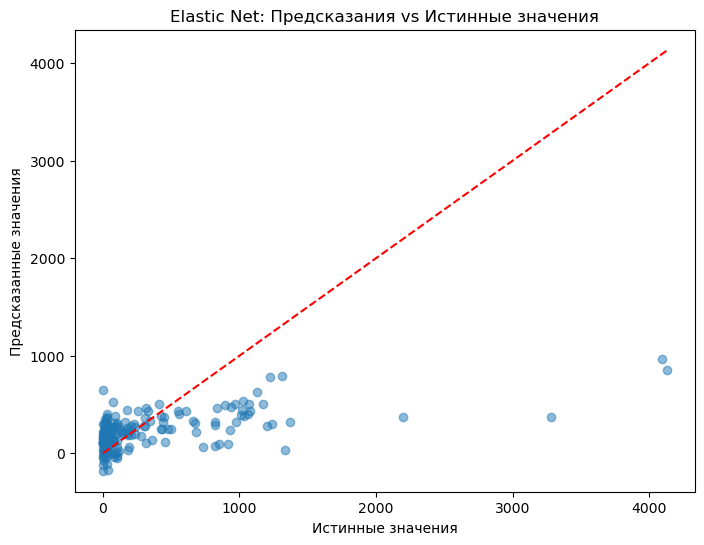

In [7]:
X = df.drop(['IC50, mM'], axis=1)
y = df['IC50, mM']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

elastic_net = ElasticNet()

# Подбор гиперпараметров с помощью GridSearchCV
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10],  # сила регуляризации
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]  # соотношение L1/L2 (0 = Ridge, 1 = Lasso)
}

grid_search = GridSearchCV(elastic_net, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

best_model = grid_search.best_estimator_
print(f"Лучшие параметры: {grid_search.best_params_}")

y_pred = best_model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.4f}")
print(f"R²: {r2:.4f}")

plt.figure(figsize=(12, 6))
features = X.columns
coef = best_model.coef_
plt.barh(features, coef)
plt.xlabel('Значение коэффициента')
plt.ylabel('Признаки')
plt.title('Важность признаков в Elastic Net')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.title('Elastic Net: Предсказания vs Истинные значения')
plt.show()

## Метод опорных векторов + PCA

Fitting 5 folds for each of 144 candidates, totalling 720 fits

Лучшие параметры: {'C': 100, 'epsilon': 0.5, 'gamma': 0.1, 'kernel': 'rbf'}
Лучший MSE (на кросс-валидации): 118255.33113421549

Результаты на тестовых данных:
MSE: 340765.4725
R²: -0.0216


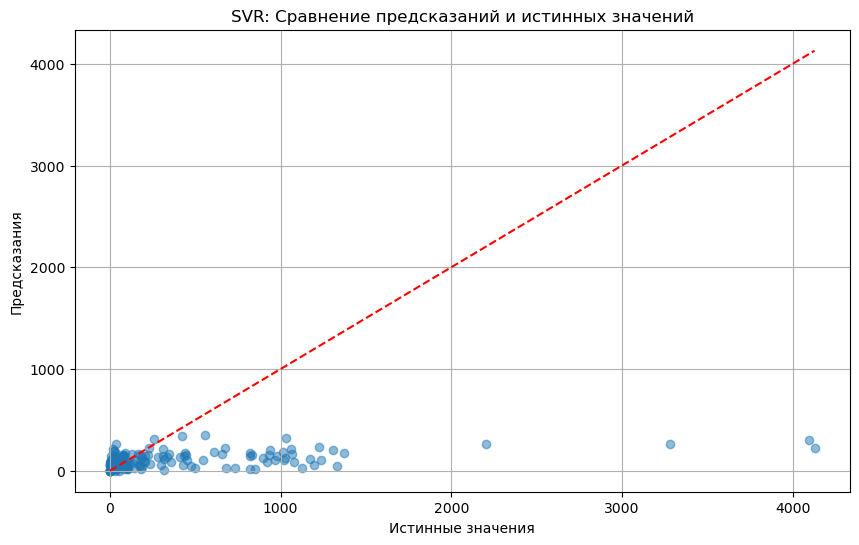

In [8]:
# X = df.drop(['IC50, mM'], axis=1)
# y = df['IC50, mM']

X = df[top_features]
y = df['IC50, mM']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1],
    'epsilon': [0.01, 0.1, 0.5]
}

svr = SVR()
grid_search = GridSearchCV(
    estimator=svr,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X_train_scaled, y_train)

print("\nЛучшие параметры:", grid_search.best_params_)
print("Лучший MSE (на кросс-валидации):", -grid_search.best_score_)

best_svr = grid_search.best_estimator_

y_pred = best_svr.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nРезультаты на тестовых данных:")
print(f"MSE: {mse:.4f}")
print(f"R²: {r2:.4f}")

# 8. Визуализация результатов
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Истинные значения')
plt.ylabel('Предсказания')
plt.title('SVR: Сравнение предсказаний и истинных значений')
plt.grid(True)
plt.show()

## Деревья решений + PCA

Лучшие параметры: {'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 5}
MSE: 202027.7754
R²: 0.3943


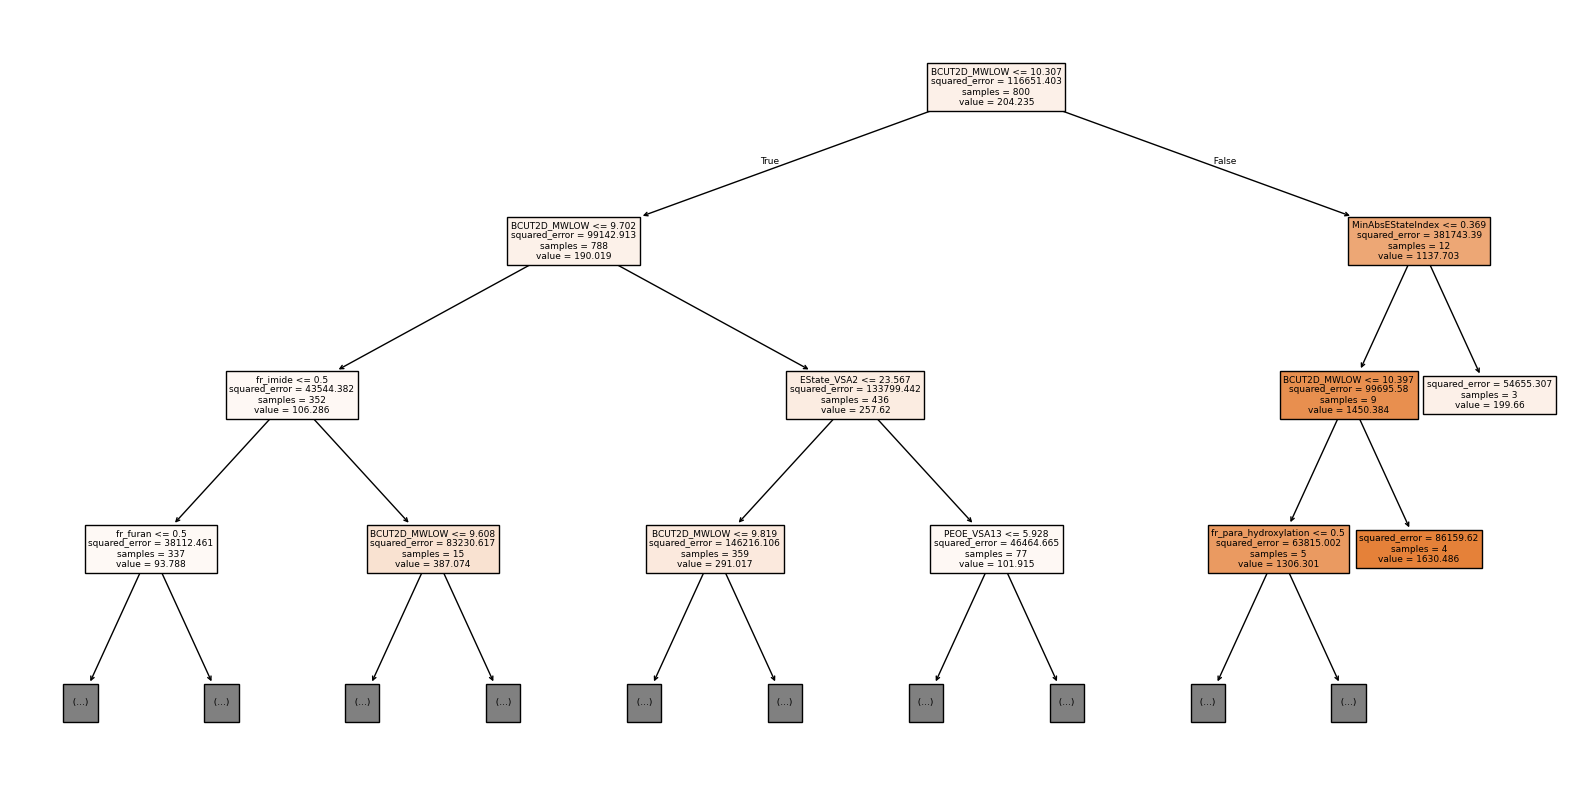

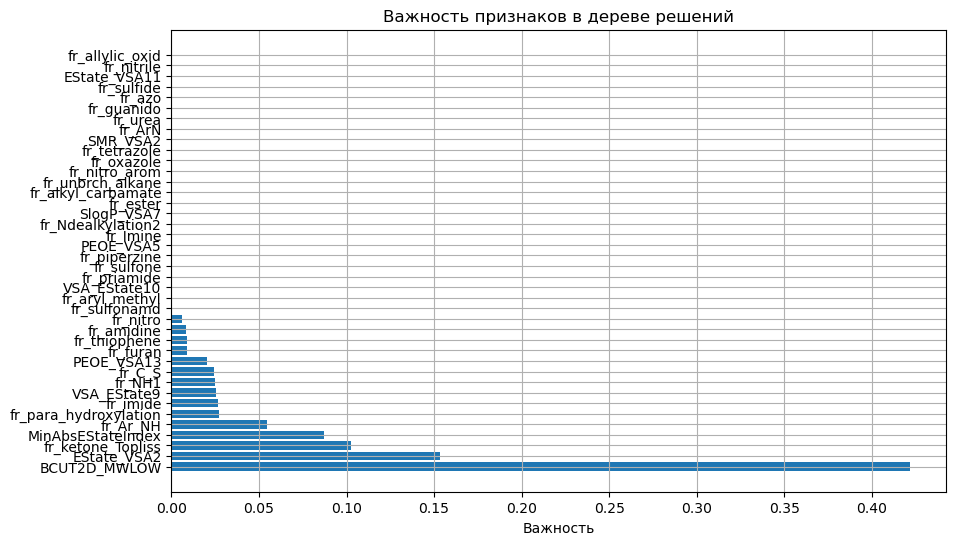

In [10]:
# X = df.drop(['IC50, mM'], axis=1)
# y = df['IC50, mM']

X = df[top_features]
y = df['IC50, mM']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dt_reg = DecisionTreeRegressor(random_state=42)
grid_search = GridSearchCV(dt_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_dt_reg = grid_search.best_estimator_
print("Лучшие параметры:", grid_search.best_params_)

y_pred = best_dt_reg.predict(X_test)
print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")
print(f"R²: {r2_score(y_test, y_pred):.4f}")

plt.figure(figsize=(20, 10))
plot_tree(best_dt_reg, max_depth=3, feature_names=X.columns, filled=True)
plt.show()

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_dt_reg.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.title('Важность признаков в дереве решений')
plt.xlabel('Важность')
plt.grid(True)
plt.show()

## Случайный лес

Лучшие параметры: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
MSE: 188538.1563
R²: 0.4348


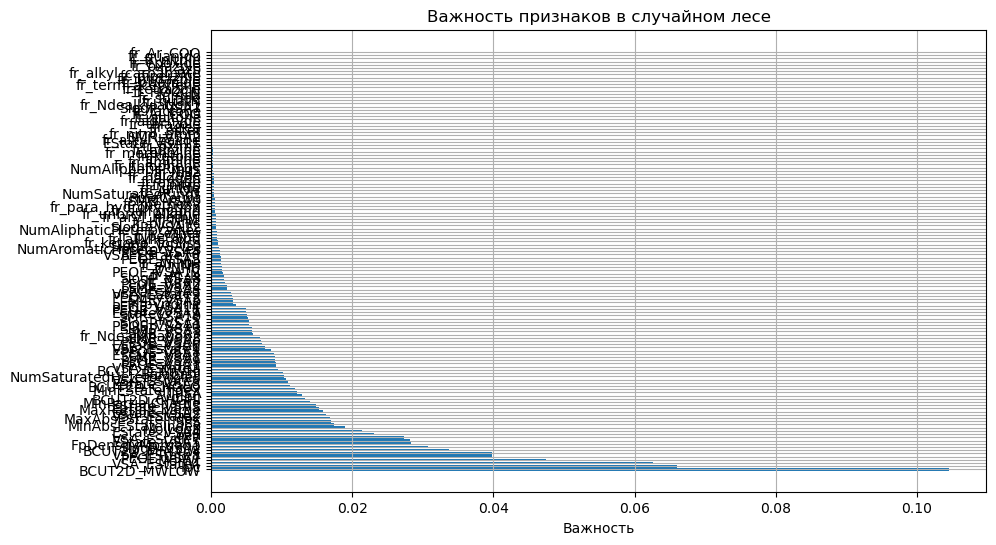

In [20]:
X = df.drop(['IC50, mM'], axis=1)
y = df['IC50, mM']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],   # Количество деревьев
    'max_depth': [None, 5, 10],       # Максимальная глубина
    'min_samples_split': [2, 5],      # Минимальное число образцов для разделения
    'min_samples_leaf': [1, 2]        # Минимальное число образцов в листе
}

rf_reg = RandomForestRegressor(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(rf_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_rf_reg = grid_search.best_estimator_
print("Лучшие параметры:", grid_search.best_params_)

y_pred = best_rf_reg.predict(X_test)
print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")
print(f"R²: {r2_score(y_test, y_pred):.4f}")

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_rf_reg.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.title('Важность признаков в случайном лесе')
plt.xlabel('Важность')
plt.grid(True)
plt.show()

## Градиентный бустинг

In [21]:
X = df.drop(['IC50, mM'], axis=1)
y = df['IC50, mM']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gbr = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.1, max_depth=3, random_state=42)
gbr.fit(X_train, y_train)

y_pred = gbr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse}")
print(f"R² Score: {r2}")

MSE: 213264.11973970057
R² Score: 0.3606409137224331


### **Анализ результатов и рекомендации**

#### **1. Сравнение моделей по качеству**
| Модель                  | R²       | MSE        | Вывод                          |
|-------------------------|----------|------------|--------------------------------|
| **Случайный лес**       | 0.4348   | 188538    | Лучший результат               |
| **Деревья решений**     | 0.3943   | 202028    | Хорошая интерпретируемость     |
| **Градиентный бустинг** | 0.3606   | 213264    | Потенциал для улучшения        |
| **Elastic Net**         | 0.2553   | 248408    | Лучшая линейная модель         |
| **Линейная регрессия**  | 0.2348   | 255240    | Базовый вариант                |
| **SVM + PCA**           | -0.0216  | 340765    | Не подходит для этих данных    |

---

#### **2. Ключевые выводы**
1. **Ансамблевые методы (Random Forest, Gradient Boosting)** показали наилучшие результаты благодаря:
   - Учету нелинейных зависимостей.
   - Устойчивости к переобучению.

2. **Дерево решений** — хороший компромисс между точностью и интерпретируемостью.

3. **Elastic Net** превзошла обычную линейную регрессию за счет:
   - L1-регуляризации (отбор признаков).
   - L2-регуляризации (борьба с мультиколлинеарностью).

4. **SVM + PCA** дал худший результат, вероятно из-за:
   - Потери информации при уменьшении размерности.
   - Неоптимального выбора ядра или параметров.

---

#### **3. Рекомендации по улучшению**
##### **Для ансамблевых методов**
1. **Увеличение количества деревьев**
2. **Глубокая настройка Gradient Boosting**


##### **Для линейных моделей**
1. **Добавление полиномиальных признаков**
2. **Более строгая регуляризация**


##### **Для SVM**
1. **Отказ от PCA** или подбор других ядер:
   ```python
   SVR(kernel='poly', degree=3)
   ```
   
---

Таким образом, сравнены различные модели с настройкой гиперпараметров, сделаны выводы о применимости методов, даны рекомендации по улучшению.